Se utilizaba feature extraction y solo se entrenaba el clasificador.

Ahora se van a descongelar la(s) ultima(s) capas del efficientNet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torch_lr_finder

In [ ]:
import pandas as pd
import os
import random
from collections import defaultdict
from PIL import Image
from pathlib import Path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
from torch_lr_finder import LRFinder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import copy
import gc

/usr/local/lib/python3.12/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # para múltiples GPUs

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Semilla aleatoria establecida en {seed}")

def get_train_transform(img_size):
    # Data augmentations
    #Se cambian a valores más moderados
    return  transforms.Compose([
    transforms.Resize((img_size, img_size)),

    #Augmentations de color
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    #transforms.GaussianBlur(kernel_size=(3, 7), sigma=(0.1, 2.0)),

    # Augmentations espaciales / de forma
    transforms.RandomHorizontalFlip(p=0.5), # Espejo
    transforms.RandomRotation(12),

    # Mueve, escala e inclina la mano
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),

    # Normalización y borrado
    transforms.ToTensor(),                   # Convertir a Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),

    # Random Erasing debe ir después de ToTensor y Normalize
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2))
])

def get_val_transform(img_size):
    #Solo se normalizan y redimensionan las imagenes del test y val
    return transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for imgs, labels in tqdm(loader, desc="Entrenando", leave=False):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = 100 * correct / total
    loss = running_loss / len(loader)
    return loss, acc

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Validando", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = 100 * correct / total
    loss = running_loss / len(loader)
    return loss, acc

def graficar_loss(history_loss_train, history_loss_val):
    plt.figure(figsize=(10, 6))
    #mostrar etiquetas para saber que linea es cada una
    plt.plot(history_loss_train)
    plt.plot(history_loss_val)
    plt.title('Loss durante el Entrenamiento')
    plt.ylabel('Loss')
    plt.legend(['Entrenamiento', 'Validación'], loc='upper right')
    plt.xlabel('Épocas')

def graficar_accuracy(history_acc_train, history_acc_val):
    plt.figure(figsize=(10, 6))
    plt.plot(history_acc_train)
    plt.plot(history_acc_val)
    plt.title('Accuracy durante el Entrenamiento')
    plt.ylabel('Accuracy')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.xlabel('Épocas')


In [ ]:
class SignLanguageDataset(Dataset):
    def __init__(self, file_list, label_map, transform=None):
        self.file_list = file_list
        self.transform = transform
        # El mapa de etiquetas se pasa desde fuera
        self.label_map = label_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]

        # La etiqueta es la carpeta
        letra = img_path.parent.name
        label = self.label_map[letra]

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error cargando imagen {img_path}: {e}")
            return torch.randn(3, 224, 224), -1

        if self.transform:
            img = self.transform(img)
        return img, label

## DATASET Integrado todo vs letras con seña igual (o muy similar)

In [ ]:
print("Descomprimiendo dataset...")
!unzip -q "/content/drive/MyDrive/IA Avanzada/Datasets/SinDiferentes2.zip" -d "/content/dataset_local/"

Descomprimiendo dataset...


In [ ]:
TRAIN_DIR = "/content/dataset_local/SinDiferentes2"
# Split 90-5-5
VAL_SPLIT_SIZE = 0.1
TEST_SPLIT_SIZE = 0.1
BATCH_SIZE = 128
SEED = 42
IMG_SIZE = 224

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsando dispositivo: {device}")
if device.type == "cuda":
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")

print(f"Escaneando {TRAIN_DIR} para crear divisiones...")
train_root = Path(TRAIN_DIR)
all_files = []
all_labels_text = [] # Guardamos A, B, ... , Z

class_names = sorted([d.name for d in train_root.iterdir() if d.is_dir()])
label_map = {class_name: idx for idx, class_name in enumerate(class_names)}
NUM_CLASSES = len(class_names)

for class_name in class_names:
    class_dir = train_root / class_name
    files = list(class_dir.glob('*.[jp][pn]g'))
    all_files.extend(files)
    all_labels_text.extend([class_name] * len(files))

print(f"Total de imágenes encontradas: {len(all_files)}")
print(f"Número de clases: {NUM_CLASSES}")

size_val_test = VAL_SPLIT_SIZE + TEST_SPLIT_SIZE

train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files,
    all_labels_text,
    test_size=size_val_test,
    random_state=SEED,
    stratify=all_labels_text
)

#Se hace la division 5% de test-val
relative_test_size = TEST_SPLIT_SIZE / size_val_test

val_files, test_files, _, _ = train_test_split(
    temp_files,
    temp_labels,
    test_size=relative_test_size,
    random_state=SEED,
    stratify=temp_labels
)

print("\n--- ¡División completada! ---")
print(f"Imágenes de Entrenamiento: {len(train_files)} ({len(train_files)/len(all_files):.0%})")
print(f"Imágenes de Validación:   {len(val_files)} ({len(val_files)/len(all_files):.0%})")
print(f"Imágenes de Prueba:       {len(test_files)} ({len(test_files)/len(all_files):.0%})")

Semilla aleatoria establecida en 42

Usando dispositivo: cuda
GPU detectada: Tesla T4
Escaneando /content/dataset_local/SinDiferentes2 para crear divisiones...
Total de imágenes encontradas: 4124
Número de clases: 26

--- ¡División completada! ---
Imágenes de Entrenamiento: 3299 (80%)
Imágenes de Validación:   412 (10%)
Imágenes de Prueba:       413 (10%)


In [ ]:
set_seed(SEED)

train_tfm = get_train_transform(IMG_SIZE)
val_tfm = get_val_transform(IMG_SIZE)

train_dataset = SignLanguageDataset(train_files, label_map, transform=train_tfm)
val_dataset = SignLanguageDataset(val_files, label_map, transform=val_tfm)
test_dataset = SignLanguageDataset(test_files, label_map, transform=val_tfm)

num_cpus = os.cpu_count()

print(f"Usando {num_cpus} workers para cargar datos...")

# DataLoaders
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=num_cpus,  # Usa todos los CPUs
                          pin_memory=True,
                          prefetch_factor=2    # Precarga 2 lotes
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        num_workers=num_cpus,
                        pin_memory=True,
                        prefetch_factor=2
                       )

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=num_cpus,
                         pin_memory=True,
                         prefetch_factor=2
                        )

print(f"\nDataLoaders listos.")
print(f"Clases: {NUM_CLASSES}")

Semilla aleatoria establecida en 42
Usando 2 workers para cargar datos...

DataLoaders listos.
Clases: 26


In [ ]:
model = models.efficientnet_b0(weights='IMAGENET1K_V1')
print(len(model.features))

9


In [ ]:
# LR ajustado para fine-tuning (más conservador que 0.01)
LR = 1e-4  # 0.0001 es un estándar seguro para descongelar bloques
EPOCHS = 50
set_seed(SEED)

model = models.efficientnet_b0(weights='IMAGENET1K_V1')

# 1. Congelar todo
for param in model.parameters():
    param.requires_grad = False


for param in model.features[8].parameters():
    param.requires_grad = True

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]

# Verificar cuántos params vamos a entrenar (Debugging útil)
print(f"Parámetros a entrenar: {len(params_to_update)}")

criterion = nn.CrossEntropyLoss()

# 5. DEFINICIÓN ÚNICA DEL OPTIMIZADOR
# Usamos la lista completa 'params_to_update' y el LR conservador
optimizer = optim.AdamW(params_to_update, lr=LR)

# (Ya no hay segunda línea de optimizer aquí)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_weights = None

print(f"Iniciando entrenamiento de EfficientNet b0 con LR={LR}...")
patience = 30
patience_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Época {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"  -> Nuevo mejor modelo encontrado (Val Loss: {val_loss:.4f}). Guardando pesos.")
    else:
        # Si no mejora, aumentamos el contador de paciencia
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  -> No mejora en {patience} épocas. Deteniendo entrenamiento.")
            break

print("\nEntrenamiento finalizado.")

# Evaluación en Test
print(f"Cargando el mejor modelo (Val Loss: {best_val_loss:.4f}) para la prueba final...")
model.load_state_dict(best_model_weights)

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Probando en Test Set"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas finales
final_loss_ef2 = test_loss / len(test_loader)
final_acc_ef2 = accuracy_score(all_labels, all_preds) * 100
final_f1_ef2 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Resultados Finales (EfficientNetb0) ---")
print(f"  -> Test Loss:      {final_loss_ef2:.4f}")
print(f"  -> Test Accuracy:  {final_acc_ef2:.2f}%")
print(f"  -> Test F1-Score (Macro): {final_f1_ef2:.4f}")
print("---------------------------------------")

Semilla aleatoria establecida en 42
Parámetros a entrenar: 5
Iniciando entrenamiento de EfficientNet b0 con LR=0.0001...


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 1/50 -> Train Loss: 3.2269, Train Acc: 6.43% | Val Loss: 3.1521, Val Acc: 11.17%
  -> Nuevo mejor modelo encontrado (Val Loss: 3.1521). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 2/50 -> Train Loss: 3.1375, Train Acc: 12.09% | Val Loss: 3.0414, Val Acc: 19.66%
  -> Nuevo mejor modelo encontrado (Val Loss: 3.0414). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 3/50 -> Train Loss: 3.0467, Train Acc: 17.37% | Val Loss: 2.9292, Val Acc: 26.46%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.9292). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 4/50 -> Train Loss: 2.9594, Train Acc: 22.07% | Val Loss: 2.8255, Val Acc: 32.04%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.8255). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 5/50 -> Train Loss: 2.8715, Train Acc: 25.89% | Val Loss: 2.7312, Val Acc: 32.52%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.7312). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 6/50 -> Train Loss: 2.7928, Train Acc: 26.67% | Val Loss: 2.6259, Val Acc: 35.92%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.6259). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 7/50 -> Train Loss: 2.7077, Train Acc: 31.43% | Val Loss: 2.5355, Val Acc: 36.89%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.5355). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 8/50 -> Train Loss: 2.6325, Train Acc: 32.83% | Val Loss: 2.4450, Val Acc: 36.89%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.4450). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 9/50 -> Train Loss: 2.5601, Train Acc: 34.46% | Val Loss: 2.3593, Val Acc: 40.05%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.3593). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 10/50 -> Train Loss: 2.4884, Train Acc: 35.83% | Val Loss: 2.2960, Val Acc: 39.81%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.2960). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 11/50 -> Train Loss: 2.4284, Train Acc: 36.98% | Val Loss: 2.2232, Val Acc: 41.99%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.2232). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 12/50 -> Train Loss: 2.3620, Train Acc: 38.28% | Val Loss: 2.1532, Val Acc: 45.63%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.1532). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 13/50 -> Train Loss: 2.3094, Train Acc: 38.95% | Val Loss: 2.1089, Val Acc: 43.93%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.1089). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 14/50 -> Train Loss: 2.2741, Train Acc: 38.74% | Val Loss: 2.0486, Val Acc: 46.36%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.0486). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 15/50 -> Train Loss: 2.1989, Train Acc: 41.62% | Val Loss: 2.0127, Val Acc: 45.39%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.0127). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 16/50 -> Train Loss: 2.1840, Train Acc: 40.68% | Val Loss: 1.9615, Val Acc: 46.36%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.9615). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 17/50 -> Train Loss: 2.1291, Train Acc: 43.62% | Val Loss: 1.9045, Val Acc: 49.03%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.9045). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 18/50 -> Train Loss: 2.1114, Train Acc: 43.56% | Val Loss: 1.8969, Val Acc: 49.03%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.8969). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 19/50 -> Train Loss: 2.0710, Train Acc: 42.95% | Val Loss: 1.8533, Val Acc: 50.73%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.8533). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 20/50 -> Train Loss: 2.0281, Train Acc: 44.01% | Val Loss: 1.8098, Val Acc: 50.73%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.8098). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 21/50 -> Train Loss: 2.0067, Train Acc: 44.86% | Val Loss: 1.7721, Val Acc: 51.94%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.7721). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 22/50 -> Train Loss: 1.9892, Train Acc: 44.53% | Val Loss: 1.7636, Val Acc: 51.21%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.7636). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 23/50 -> Train Loss: 1.9617, Train Acc: 45.92% | Val Loss: 1.7309, Val Acc: 52.67%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.7309). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 24/50 -> Train Loss: 1.9611, Train Acc: 44.32% | Val Loss: 1.6935, Val Acc: 52.18%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.6935). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 25/50 -> Train Loss: 1.9129, Train Acc: 46.20% | Val Loss: 1.6654, Val Acc: 51.94%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.6654). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 26/50 -> Train Loss: 1.9011, Train Acc: 46.89% | Val Loss: 1.6688, Val Acc: 52.18%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 27/50 -> Train Loss: 1.8882, Train Acc: 47.29% | Val Loss: 1.6390, Val Acc: 53.40%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.6390). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 28/50 -> Train Loss: 1.8506, Train Acc: 47.65% | Val Loss: 1.6060, Val Acc: 55.83%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.6060). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 29/50 -> Train Loss: 1.8566, Train Acc: 46.89% | Val Loss: 1.6163, Val Acc: 53.64%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 30/50 -> Train Loss: 1.8259, Train Acc: 48.86% | Val Loss: 1.5708, Val Acc: 55.58%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.5708). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 31/50 -> Train Loss: 1.7986, Train Acc: 48.44% | Val Loss: 1.5587, Val Acc: 56.07%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.5587). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 32/50 -> Train Loss: 1.7905, Train Acc: 50.20% | Val Loss: 1.5517, Val Acc: 55.83%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.5517). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 33/50 -> Train Loss: 1.7942, Train Acc: 49.17% | Val Loss: 1.5196, Val Acc: 56.07%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.5196). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 34/50 -> Train Loss: 1.7849, Train Acc: 50.83% | Val Loss: 1.4989, Val Acc: 57.77%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4989). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 35/50 -> Train Loss: 1.7600, Train Acc: 49.38% | Val Loss: 1.5033, Val Acc: 58.25%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 36/50 -> Train Loss: 1.7752, Train Acc: 49.41% | Val Loss: 1.4806, Val Acc: 57.28%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4806). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 37/50 -> Train Loss: 1.7620, Train Acc: 49.71% | Val Loss: 1.4677, Val Acc: 58.01%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4677). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 38/50 -> Train Loss: 1.7179, Train Acc: 49.71% | Val Loss: 1.4511, Val Acc: 58.98%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4511). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 39/50 -> Train Loss: 1.7310, Train Acc: 49.92% | Val Loss: 1.4791, Val Acc: 56.31%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 40/50 -> Train Loss: 1.7145, Train Acc: 50.89% | Val Loss: 1.4506, Val Acc: 58.25%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4506). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 41/50 -> Train Loss: 1.6997, Train Acc: 50.83% | Val Loss: 1.4027, Val Acc: 60.44%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4027). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 42/50 -> Train Loss: 1.7285, Train Acc: 50.26% | Val Loss: 1.4062, Val Acc: 59.71%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 43/50 -> Train Loss: 1.6900, Train Acc: 51.32% | Val Loss: 1.4059, Val Acc: 60.92%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 44/50 -> Train Loss: 1.6597, Train Acc: 53.32% | Val Loss: 1.4003, Val Acc: 59.71%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4003). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 45/50 -> Train Loss: 1.6819, Train Acc: 52.08% | Val Loss: 1.3705, Val Acc: 61.41%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3705). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 46/50 -> Train Loss: 1.6482, Train Acc: 53.02% | Val Loss: 1.3845, Val Acc: 62.14%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 47/50 -> Train Loss: 1.6659, Train Acc: 51.20% | Val Loss: 1.3713, Val Acc: 61.65%


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 48/50 -> Train Loss: 1.6305, Train Acc: 53.23% | Val Loss: 1.3584, Val Acc: 61.65%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3584). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 49/50 -> Train Loss: 1.6348, Train Acc: 52.96% | Val Loss: 1.3491, Val Acc: 62.62%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3491). Guardando pesos.


Entrenando:   0%|          | 0/52 [00:00<?, ?it/s]

Validando:   0%|          | 0/7 [00:00<?, ?it/s]

Época 50/50 -> Train Loss: 1.6357, Train Acc: 52.80% | Val Loss: 1.3481, Val Acc: 60.19%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3481). Guardando pesos.

Entrenamiento finalizado.
Cargando el mejor modelo (Val Loss: 1.3481) para la prueba final...


Probando en Test Set:   0%|          | 0/7 [00:00<?, ?it/s]


--- Resultados Finales (EfficientNetb0) ---
  -> Test Loss:      1.4043
  -> Test Accuracy:  57.63%
  -> Test F1-Score (Macro): 0.5750
---------------------------------------


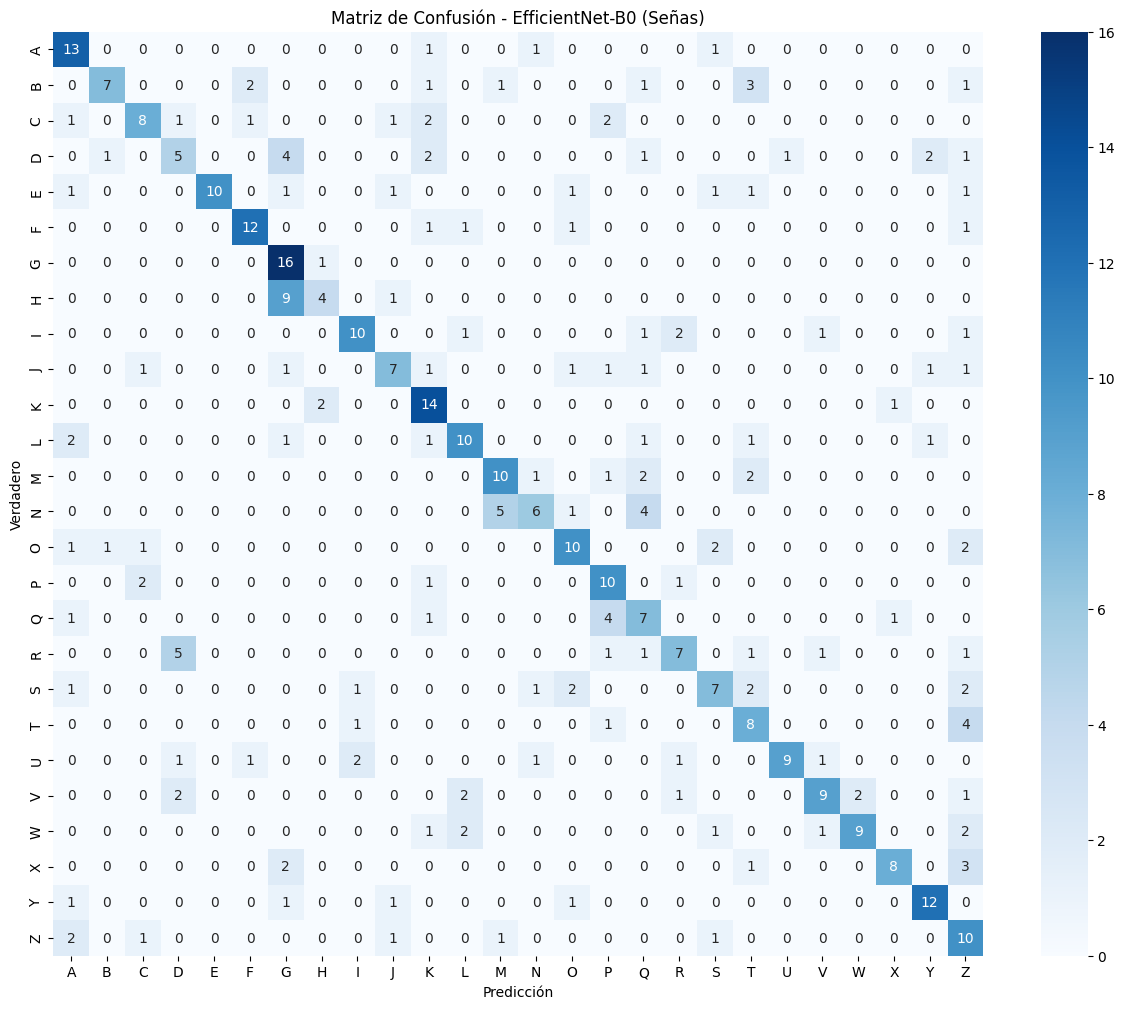

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.label_map.keys(),  # Usar los nombres de clases
            yticklabels=train_dataset.label_map.keys()) # Usar los nombres de clases
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - EfficientNet-B0 (Señas)')
plt.show()

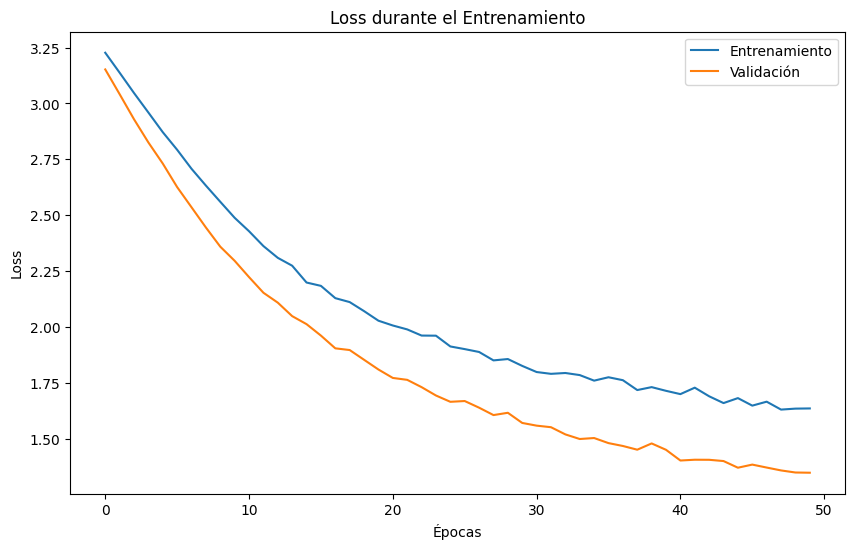

In [ ]:
graficar_loss(history['train_loss'], history['val_loss'])

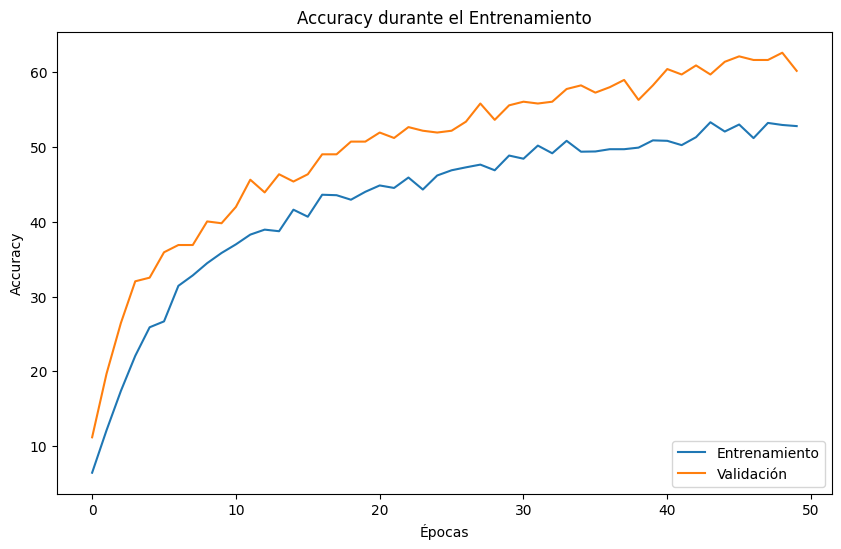

In [ ]:
graficar_accuracy(history['train_acc'], history['val_acc'])

In [ ]:
#Borrar memoria
del model
del train_dataset
del val_dataset
del test_dataset
del train_loader
del val_loader
del test_loader
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# LR ajustado para fine-tuning (más conservador que 0.01)
LR = 1e-4
EPOCHS = 50
set_seed(SEED)

model = models.efficientnet_b0(weights='IMAGENET1K_V1')

#Congelar todo primero
for param in model.parameters():
    param.requires_grad = False

print("Descongelando bloques 7 y 8...")
for block in [7, 8]:
    for param in model.features[block].parameters():
        param.requires_grad = True

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_update, lr=LR)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_weights = None

print(f"Iniciando entrenamiento de EfficientNet b0 con LR={LR}...")
patience = 30
patience_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Época {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"  -> Nuevo mejor modelo encontrado (Val Loss: {val_loss:.4f}). Guardando pesos.")
    else:
        # Si no mejora, aumentamos el contador de paciencia
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  -> No mejora en {patience} épocas. Deteniendo entrenamiento.")
            break

print("\nEntrenamiento finalizado.")

# Evaluación en Test
print(f"Cargando el mejor modelo (Val Loss: {best_val_loss:.4f}) para la prueba final...")
model.load_state_dict(best_model_weights)

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Probando en Test Set"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas finales
final_loss_ef2 = test_loss / len(test_loader)
final_acc_ef2 = accuracy_score(all_labels, all_preds) * 100
final_f1_ef2 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Resultados Finales (EfficientNetb0) ---")
print(f"  -> Test Loss:      {final_loss_ef2:.4f}")
print(f"  -> Test Accuracy:  {final_acc_ef2:.2f}%")
print(f"  -> Test F1-Score (Macro): {final_f1_ef2:.4f}")
print("---------------------------------------")

Semilla aleatoria establecida en 42
Descongelando bloques 6, 7 y 8...
Iniciando entrenamiento de EfficientNet b0 con LR=0.0001...


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 1/50 -> Train Loss: 3.2268, Train Acc: 6.79% | Val Loss: 3.2109, Val Acc: 8.25%
  -> Nuevo mejor modelo encontrado (Val Loss: 3.2109). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 2/50 -> Train Loss: 3.1247, Train Acc: 12.64% | Val Loss: 3.0097, Val Acc: 22.82%
  -> Nuevo mejor modelo encontrado (Val Loss: 3.0097). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 3/50 -> Train Loss: 3.0015, Train Acc: 20.28% | Val Loss: 2.8336, Val Acc: 32.28%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.8336). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 4/50 -> Train Loss: 2.8484, Train Acc: 25.95% | Val Loss: 2.6299, Val Acc: 38.11%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.6299). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 5/50 -> Train Loss: 2.6776, Train Acc: 31.62% | Val Loss: 2.4406, Val Acc: 40.78%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.4406). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 6/50 -> Train Loss: 2.5120, Train Acc: 35.19% | Val Loss: 2.2434, Val Acc: 48.06%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.2434). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 7/50 -> Train Loss: 2.3594, Train Acc: 38.44% | Val Loss: 2.0872, Val Acc: 51.21%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.0872). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 8/50 -> Train Loss: 2.2129, Train Acc: 41.25% | Val Loss: 1.9662, Val Acc: 53.64%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.9662). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 9/50 -> Train Loss: 2.1160, Train Acc: 42.86% | Val Loss: 1.8330, Val Acc: 55.58%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.8330). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 10/50 -> Train Loss: 1.9952, Train Acc: 45.41% | Val Loss: 1.7656, Val Acc: 55.34%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.7656). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 11/50 -> Train Loss: 1.9013, Train Acc: 48.29% | Val Loss: 1.6698, Val Acc: 57.77%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.6698). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 12/50 -> Train Loss: 1.8483, Train Acc: 47.89% | Val Loss: 1.5808, Val Acc: 60.19%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.5808). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 13/50 -> Train Loss: 1.7815, Train Acc: 50.20% | Val Loss: 1.5393, Val Acc: 58.98%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.5393). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 14/50 -> Train Loss: 1.7406, Train Acc: 51.05% | Val Loss: 1.4652, Val Acc: 63.35%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4652). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 15/50 -> Train Loss: 1.6737, Train Acc: 52.74% | Val Loss: 1.4266, Val Acc: 63.35%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4266). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 16/50 -> Train Loss: 1.6513, Train Acc: 52.14% | Val Loss: 1.3904, Val Acc: 65.78%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3904). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 17/50 -> Train Loss: 1.6061, Train Acc: 53.56% | Val Loss: 1.3346, Val Acc: 64.81%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3346). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 18/50 -> Train Loss: 1.5497, Train Acc: 56.08% | Val Loss: 1.3015, Val Acc: 66.50%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.3015). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 19/50 -> Train Loss: 1.5343, Train Acc: 55.68% | Val Loss: 1.2716, Val Acc: 66.75%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.2716). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 20/50 -> Train Loss: 1.5032, Train Acc: 56.62% | Val Loss: 1.2379, Val Acc: 66.99%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.2379). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 21/50 -> Train Loss: 1.4755, Train Acc: 58.05% | Val Loss: 1.2075, Val Acc: 67.72%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.2075). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 22/50 -> Train Loss: 1.4303, Train Acc: 58.44% | Val Loss: 1.1887, Val Acc: 68.20%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.1887). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 23/50 -> Train Loss: 1.4066, Train Acc: 59.44% | Val Loss: 1.1615, Val Acc: 68.20%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.1615). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 24/50 -> Train Loss: 1.3983, Train Acc: 59.29% | Val Loss: 1.1396, Val Acc: 69.66%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.1396). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 25/50 -> Train Loss: 1.3836, Train Acc: 59.26% | Val Loss: 1.1165, Val Acc: 69.66%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.1165). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 26/50 -> Train Loss: 1.3526, Train Acc: 60.05% | Val Loss: 1.0877, Val Acc: 70.15%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.0877). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 27/50 -> Train Loss: 1.3413, Train Acc: 60.08% | Val Loss: 1.0709, Val Acc: 71.12%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.0709). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 28/50 -> Train Loss: 1.3181, Train Acc: 61.35% | Val Loss: 1.0561, Val Acc: 71.12%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.0561). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 29/50 -> Train Loss: 1.3208, Train Acc: 61.35% | Val Loss: 1.0271, Val Acc: 73.06%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.0271). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 30/50 -> Train Loss: 1.3004, Train Acc: 61.05% | Val Loss: 1.0090, Val Acc: 73.30%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.0090). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 31/50 -> Train Loss: 1.2829, Train Acc: 61.84% | Val Loss: 0.9958, Val Acc: 73.06%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9958). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 32/50 -> Train Loss: 1.2477, Train Acc: 62.69% | Val Loss: 0.9831, Val Acc: 73.54%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9831). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 33/50 -> Train Loss: 1.2755, Train Acc: 61.66% | Val Loss: 0.9648, Val Acc: 74.03%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9648). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 34/50 -> Train Loss: 1.2255, Train Acc: 62.17% | Val Loss: 0.9426, Val Acc: 75.00%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9426). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 35/50 -> Train Loss: 1.2074, Train Acc: 64.05% | Val Loss: 0.9438, Val Acc: 75.00%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 36/50 -> Train Loss: 1.2338, Train Acc: 62.87% | Val Loss: 0.9299, Val Acc: 76.21%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9299). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 37/50 -> Train Loss: 1.1883, Train Acc: 64.57% | Val Loss: 0.9114, Val Acc: 75.73%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9114). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 38/50 -> Train Loss: 1.1775, Train Acc: 64.96% | Val Loss: 0.9007, Val Acc: 76.21%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9007). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 39/50 -> Train Loss: 1.1969, Train Acc: 63.72% | Val Loss: 0.9080, Val Acc: 75.73%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 40/50 -> Train Loss: 1.1644, Train Acc: 64.75% | Val Loss: 0.8933, Val Acc: 76.21%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8933). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 41/50 -> Train Loss: 1.1419, Train Acc: 66.05% | Val Loss: 0.8666, Val Acc: 76.94%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8666). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 42/50 -> Train Loss: 1.1804, Train Acc: 64.87% | Val Loss: 0.8686, Val Acc: 77.67%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 43/50 -> Train Loss: 1.1427, Train Acc: 65.23% | Val Loss: 0.8609, Val Acc: 77.18%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8609). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 44/50 -> Train Loss: 1.1263, Train Acc: 66.54% | Val Loss: 0.8539, Val Acc: 76.94%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8539). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 45/50 -> Train Loss: 1.1007, Train Acc: 67.51% | Val Loss: 0.8316, Val Acc: 77.43%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8316). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 46/50 -> Train Loss: 1.0832, Train Acc: 67.11% | Val Loss: 0.8315, Val Acc: 76.70%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8315). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 47/50 -> Train Loss: 1.1005, Train Acc: 65.87% | Val Loss: 0.8216, Val Acc: 77.18%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8216). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 48/50 -> Train Loss: 1.1225, Train Acc: 66.14% | Val Loss: 0.8222, Val Acc: 77.91%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 49/50 -> Train Loss: 1.0793, Train Acc: 67.69% | Val Loss: 0.7990, Val Acc: 78.64%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.7990). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 50/50 -> Train Loss: 1.0591, Train Acc: 68.08% | Val Loss: 0.8013, Val Acc: 78.16%

Entrenamiento finalizado.
Cargando el mejor modelo (Val Loss: 0.7990) para la prueba final...


Probando en Test Set:   0%|          | 0/4 [00:00<?, ?it/s]


--- Resultados Finales (EfficientNetb0) ---
  -> Test Loss:      0.8266
  -> Test Accuracy:  77.97%
  -> Test F1-Score (Macro): 0.7795
---------------------------------------


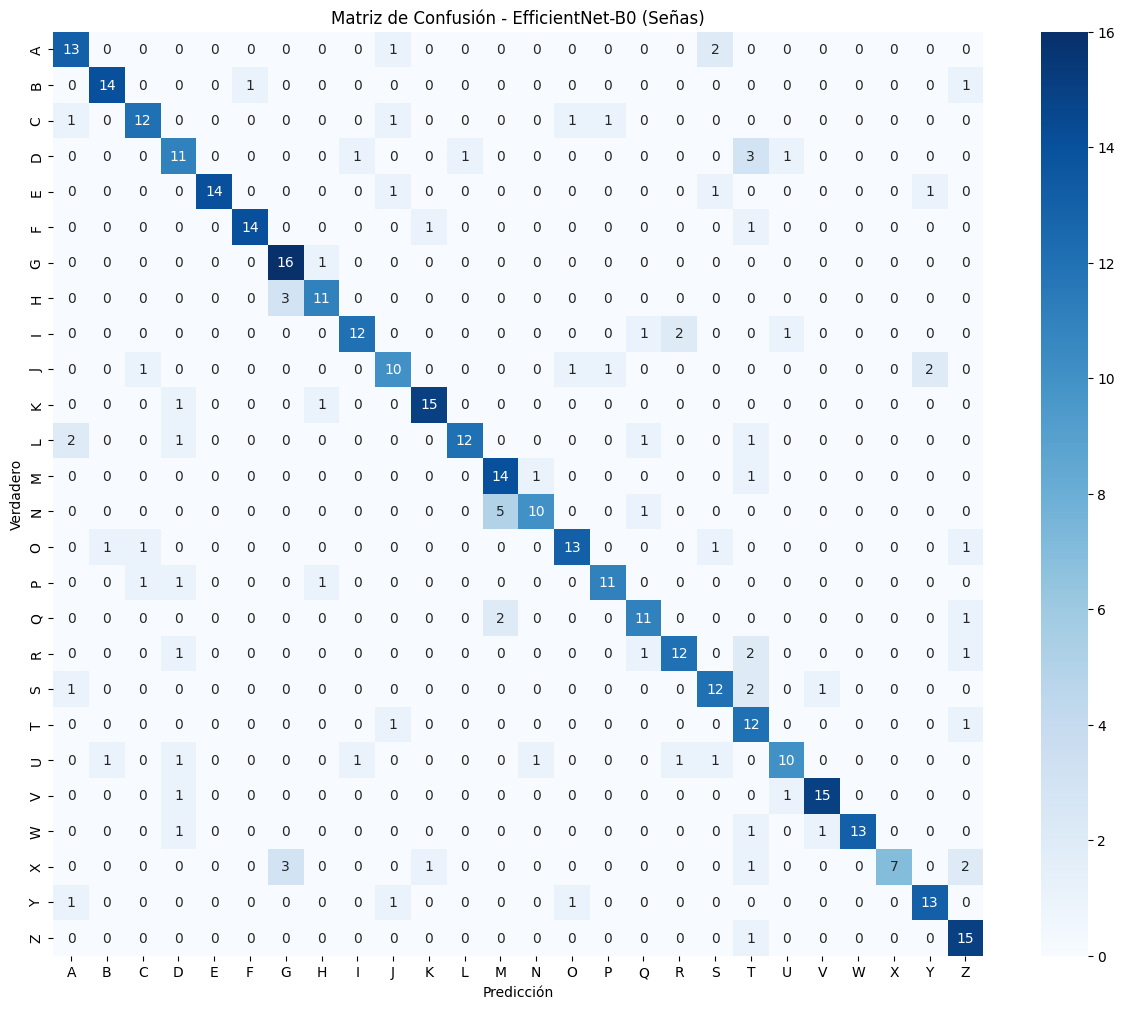

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.label_map.keys(),  # Usar los nombres de clases
            yticklabels=train_dataset.label_map.keys()) # Usar los nombres de clases
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - EfficientNet-B0 (Señas)')
plt.show()

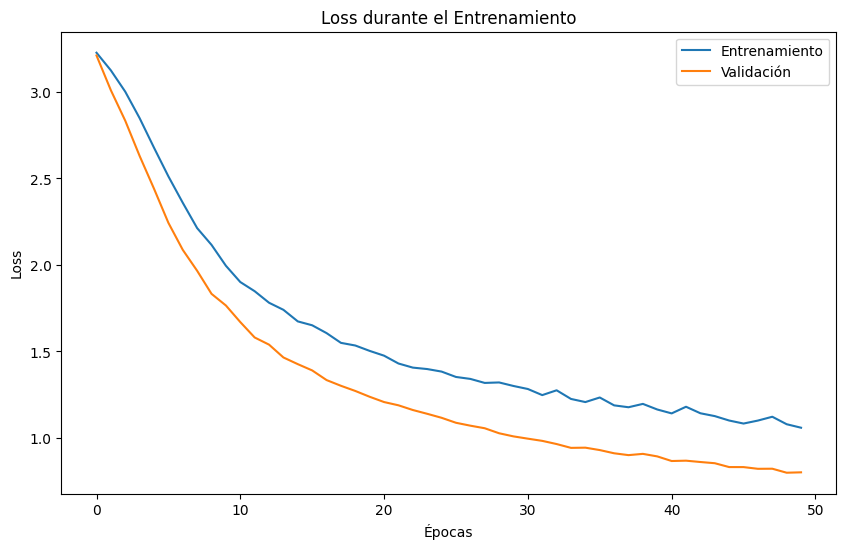

In [ ]:
graficar_loss(history['train_loss'], history['val_loss'])

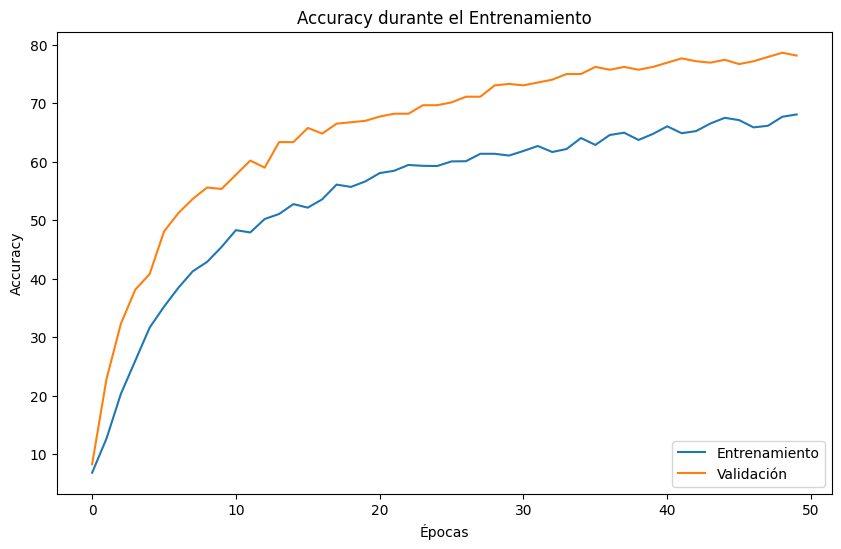

In [ ]:
graficar_accuracy(history['train_acc'],history['val_acc'])

In [ ]:
# LR ajustado para fine-tuning (más conservador que 0.01)
LR = 1e-4
EPOCHS = 50
set_seed(SEED)

model = models.efficientnet_b0(weights='IMAGENET1K_V1')

#Congelar todo primero
for param in model.parameters():
    param.requires_grad = False

# Descongelar Bloques 6, 7 y 8 (AHORA SÍ)
# Antes solo tenías el 8. Ahora sumamos 6 y 7.
print("Descongelando bloques 6, 7 y 8...")
for block in [6, 7, 8]:
    for param in model.features[block].parameters():
        param.requires_grad = True

in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)
model = model.to(device)

params_to_update = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(params_to_update, lr=LR)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
best_model_weights = None

print(f"Iniciando entrenamiento de EfficientNet b0 con LR={LR}...")
patience = 30
patience_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Época {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        print(f"  -> Nuevo mejor modelo encontrado (Val Loss: {val_loss:.4f}). Guardando pesos.")
    else:
        # Si no mejora, aumentamos el contador de paciencia
        patience_counter += 1
        if patience_counter >= patience:
            print(f"  -> No mejora en {patience} épocas. Deteniendo entrenamiento.")
            break

print("\nEntrenamiento finalizado.")

# Evaluación en Test
print(f"Cargando el mejor modelo (Val Loss: {best_val_loss:.4f}) para la prueba final...")
model.load_state_dict(best_model_weights)

model.eval()
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Probando en Test Set"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Métricas finales
final_loss_ef2 = test_loss / len(test_loader)
final_acc_ef2 = accuracy_score(all_labels, all_preds) * 100
final_f1_ef2 = f1_score(all_labels, all_preds, average='macro')

print("\n--- Resultados Finales (EfficientNetb0) ---")
print(f"  -> Test Loss:      {final_loss_ef2:.4f}")
print(f"  -> Test Accuracy:  {final_acc_ef2:.2f}%")
print(f"  -> Test F1-Score (Macro): {final_f1_ef2:.4f}")
print("---------------------------------------")

Semilla aleatoria establecida en 42
Descongelando bloques 6, 7 y 8...
Iniciando entrenamiento de EfficientNet b0 con LR=0.0001...


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 1/50 -> Train Loss: 3.2091, Train Acc: 8.00% | Val Loss: 3.1630, Val Acc: 12.14%
  -> Nuevo mejor modelo encontrado (Val Loss: 3.1630). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 2/50 -> Train Loss: 3.0346, Train Acc: 18.55% | Val Loss: 2.7760, Val Acc: 38.11%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.7760). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 3/50 -> Train Loss: 2.7399, Train Acc: 31.86% | Val Loss: 2.3023, Val Acc: 50.73%
  -> Nuevo mejor modelo encontrado (Val Loss: 2.3023). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 4/50 -> Train Loss: 2.3440, Train Acc: 40.01% | Val Loss: 1.9182, Val Acc: 55.83%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.9182). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 5/50 -> Train Loss: 2.0047, Train Acc: 47.11% | Val Loss: 1.6308, Val Acc: 60.44%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.6308). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 6/50 -> Train Loss: 1.7451, Train Acc: 52.83% | Val Loss: 1.4361, Val Acc: 65.53%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.4361). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 7/50 -> Train Loss: 1.5598, Train Acc: 56.81% | Val Loss: 1.2714, Val Acc: 70.87%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.2714). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 8/50 -> Train Loss: 1.4162, Train Acc: 61.14% | Val Loss: 1.1389, Val Acc: 71.84%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.1389). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 9/50 -> Train Loss: 1.3138, Train Acc: 63.11% | Val Loss: 1.0338, Val Acc: 74.03%
  -> Nuevo mejor modelo encontrado (Val Loss: 1.0338). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 10/50 -> Train Loss: 1.2231, Train Acc: 65.20% | Val Loss: 0.9468, Val Acc: 76.94%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.9468). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 11/50 -> Train Loss: 1.1270, Train Acc: 68.05% | Val Loss: 0.8673, Val Acc: 76.21%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.8673). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 12/50 -> Train Loss: 1.0842, Train Acc: 69.05% | Val Loss: 0.7862, Val Acc: 79.85%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.7862). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 13/50 -> Train Loss: 1.0419, Train Acc: 69.84% | Val Loss: 0.7551, Val Acc: 78.40%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.7551). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 14/50 -> Train Loss: 1.0006, Train Acc: 71.02% | Val Loss: 0.7102, Val Acc: 80.58%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.7102). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 15/50 -> Train Loss: 0.9510, Train Acc: 72.02% | Val Loss: 0.6976, Val Acc: 81.31%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.6976). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 16/50 -> Train Loss: 0.9356, Train Acc: 72.63% | Val Loss: 0.6408, Val Acc: 83.74%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.6408). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 17/50 -> Train Loss: 0.8847, Train Acc: 73.63% | Val Loss: 0.6326, Val Acc: 83.01%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.6326). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 18/50 -> Train Loss: 0.8355, Train Acc: 75.69% | Val Loss: 0.6254, Val Acc: 83.98%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.6254). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 19/50 -> Train Loss: 0.8396, Train Acc: 74.72% | Val Loss: 0.5917, Val Acc: 84.71%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.5917). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 20/50 -> Train Loss: 0.8010, Train Acc: 75.96% | Val Loss: 0.5635, Val Acc: 84.95%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.5635). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 21/50 -> Train Loss: 0.8007, Train Acc: 76.02% | Val Loss: 0.5486, Val Acc: 86.17%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.5486). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 22/50 -> Train Loss: 0.7545, Train Acc: 77.90% | Val Loss: 0.5328, Val Acc: 86.89%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.5328). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 23/50 -> Train Loss: 0.7425, Train Acc: 77.08% | Val Loss: 0.5134, Val Acc: 87.14%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.5134). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 24/50 -> Train Loss: 0.7293, Train Acc: 77.84% | Val Loss: 0.5224, Val Acc: 88.11%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 25/50 -> Train Loss: 0.7140, Train Acc: 78.57% | Val Loss: 0.4980, Val Acc: 87.62%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4980). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 26/50 -> Train Loss: 0.7035, Train Acc: 79.18% | Val Loss: 0.4787, Val Acc: 86.17%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4787). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 27/50 -> Train Loss: 0.6925, Train Acc: 78.27% | Val Loss: 0.4715, Val Acc: 88.35%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4715). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 28/50 -> Train Loss: 0.6739, Train Acc: 79.93% | Val Loss: 0.4711, Val Acc: 89.08%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4711). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 29/50 -> Train Loss: 0.6714, Train Acc: 79.45% | Val Loss: 0.4444, Val Acc: 89.56%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4444). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 30/50 -> Train Loss: 0.6444, Train Acc: 80.39% | Val Loss: 0.4494, Val Acc: 89.08%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 31/50 -> Train Loss: 0.6661, Train Acc: 79.69% | Val Loss: 0.4374, Val Acc: 88.35%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4374). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 32/50 -> Train Loss: 0.6469, Train Acc: 80.18% | Val Loss: 0.4368, Val Acc: 87.86%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4368). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 33/50 -> Train Loss: 0.6239, Train Acc: 81.02% | Val Loss: 0.4223, Val Acc: 89.32%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4223). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 34/50 -> Train Loss: 0.5986, Train Acc: 81.24% | Val Loss: 0.4323, Val Acc: 89.32%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 35/50 -> Train Loss: 0.5773, Train Acc: 82.69% | Val Loss: 0.4521, Val Acc: 88.35%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 36/50 -> Train Loss: 0.6174, Train Acc: 80.33% | Val Loss: 0.4358, Val Acc: 89.81%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 37/50 -> Train Loss: 0.5724, Train Acc: 82.39% | Val Loss: 0.4306, Val Acc: 90.05%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 38/50 -> Train Loss: 0.5706, Train Acc: 82.36% | Val Loss: 0.4071, Val Acc: 89.08%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.4071). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 39/50 -> Train Loss: 0.5751, Train Acc: 81.81% | Val Loss: 0.4088, Val Acc: 89.08%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 40/50 -> Train Loss: 0.5753, Train Acc: 82.12% | Val Loss: 0.4089, Val Acc: 90.05%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 41/50 -> Train Loss: 0.5487, Train Acc: 82.12% | Val Loss: 0.4103, Val Acc: 90.53%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 42/50 -> Train Loss: 0.5641, Train Acc: 82.42% | Val Loss: 0.4230, Val Acc: 90.05%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 43/50 -> Train Loss: 0.5295, Train Acc: 83.36% | Val Loss: 0.3808, Val Acc: 89.08%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.3808). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 44/50 -> Train Loss: 0.5377, Train Acc: 83.72% | Val Loss: 0.3936, Val Acc: 89.81%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 45/50 -> Train Loss: 0.4911, Train Acc: 84.75% | Val Loss: 0.3816, Val Acc: 90.05%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 46/50 -> Train Loss: 0.5040, Train Acc: 84.42% | Val Loss: 0.3680, Val Acc: 89.08%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.3680). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 47/50 -> Train Loss: 0.5117, Train Acc: 84.06% | Val Loss: 0.3767, Val Acc: 90.53%


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 48/50 -> Train Loss: 0.5123, Train Acc: 83.81% | Val Loss: 0.3642, Val Acc: 90.29%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.3642). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 49/50 -> Train Loss: 0.4951, Train Acc: 84.60% | Val Loss: 0.3476, Val Acc: 90.29%
  -> Nuevo mejor modelo encontrado (Val Loss: 0.3476). Guardando pesos.


Entrenando:   0%|          | 0/26 [00:00<?, ?it/s]

Validando:   0%|          | 0/4 [00:00<?, ?it/s]

Época 50/50 -> Train Loss: 0.4843, Train Acc: 85.24% | Val Loss: 0.3487, Val Acc: 90.78%

Entrenamiento finalizado.
Cargando el mejor modelo (Val Loss: 0.3476) para la prueba final...


Probando en Test Set:   0%|          | 0/4 [00:00<?, ?it/s]


--- Resultados Finales (EfficientNetb0) ---
  -> Test Loss:      0.4297
  -> Test Accuracy:  85.71%
  -> Test F1-Score (Macro): 0.8571
---------------------------------------


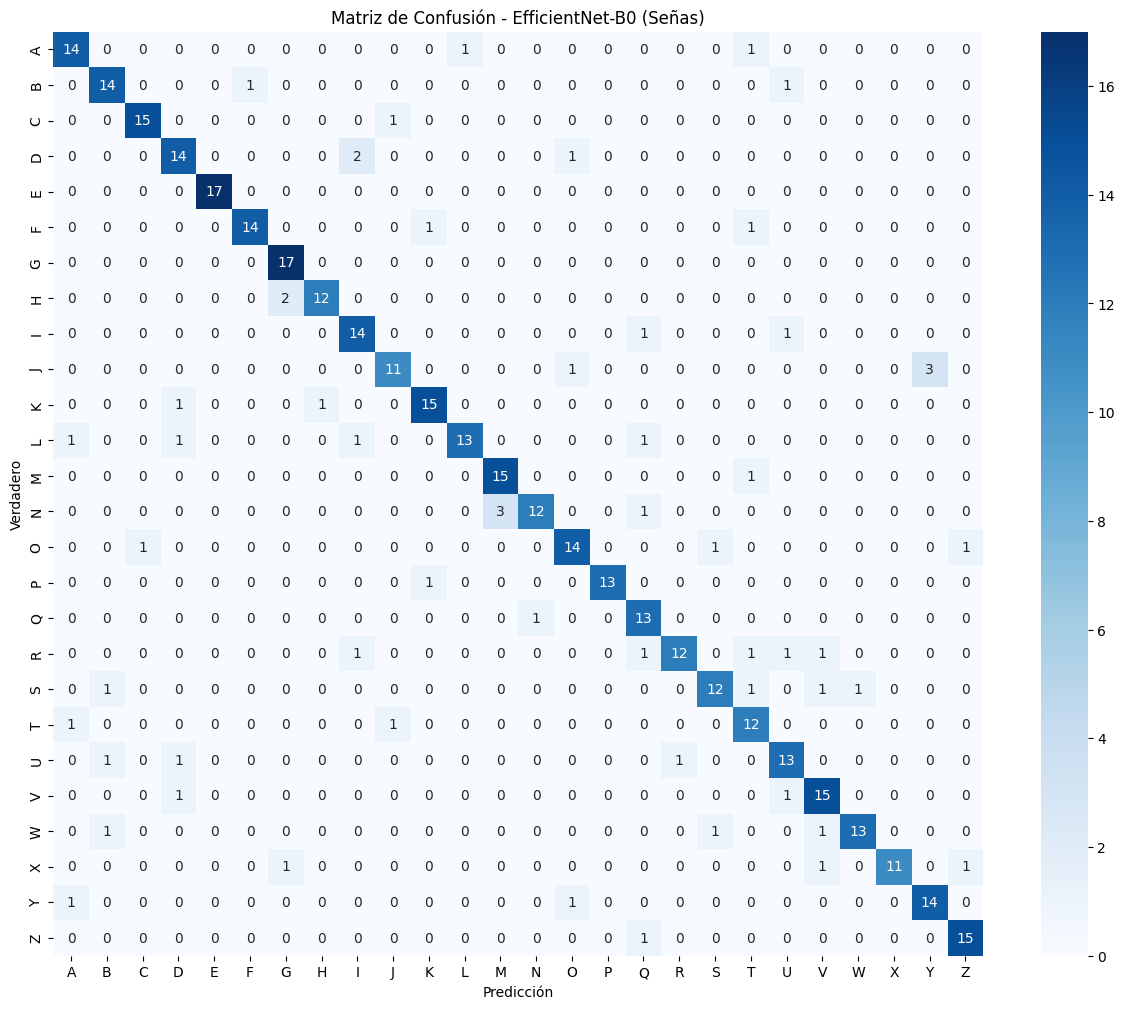

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.label_map.keys(),  # Usar los nombres de clases
            yticklabels=train_dataset.label_map.keys()) # Usar los nombres de clases
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.title('Matriz de Confusión - EfficientNet-B0 (Señas)')
plt.show()

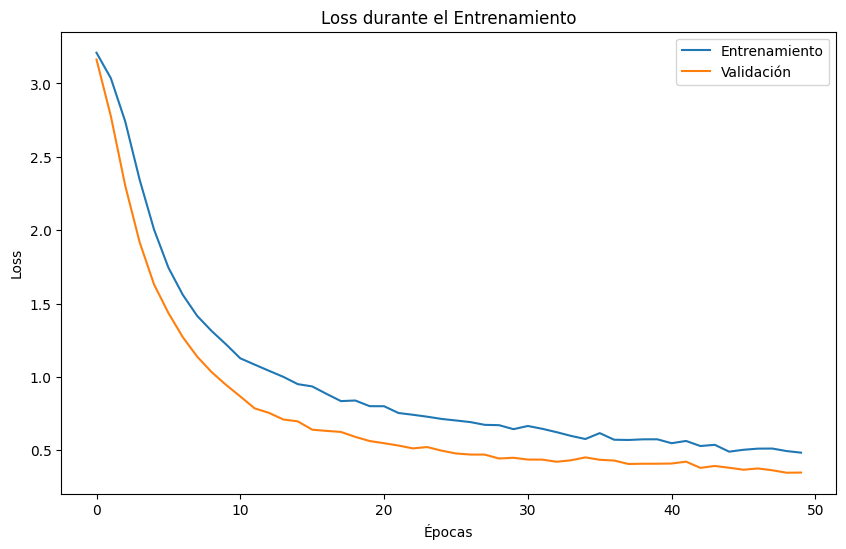

In [ ]:
graficar_loss(history['train_loss'], history['val_loss'])

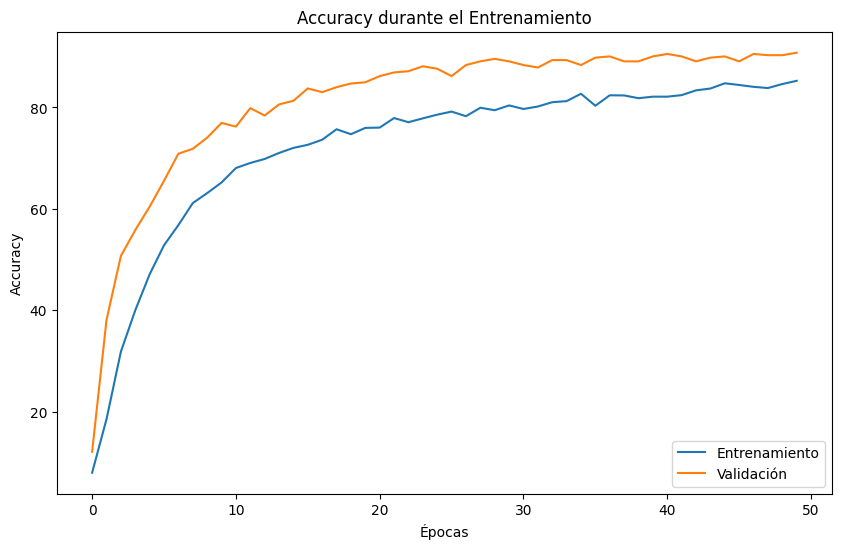

In [ ]:
graficar_accuracy(history['train_acc'], history['val_acc'])

In [ ]:
#Borrar memoria
del model
del train_dataset
del val_dataset
del test_dataset
del train_loader
del val_loader
del test_loader
gc.collect()
torch.cuda.empty_cache()